In [34]:
# -*- coding: utf-8 -*-# -*- c 
from __future__ import print_function
from __future__ import division
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import pandas as pd
from copy import copy, deepcopy
import csv
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import and Cleaning
### Visually measured height and noting water discharges
Height was measured manually using images from Wim's camera( 17th November 2016 to 7th April 2017 ). The images were programmed to be taken every 2 hours from 7 am to 4 pm. Typically a day had 4 data points. From the images fountain discharge was also noted using binary values.

In [35]:
dfheight=pd.read_csv('../data/raw/Results from Val_Roseg_Timelapse in µm per sec.csv')
dfw=pd.read_csv('../data/raw/water_dates.csv',parse_dates=['time'])

### Extracted Image times from timelapse imagery

In [36]:
dfdates=pd.read_csv('../data/raw/image_dates.csv',parse_dates=['time'])

### Importing weather data

In [37]:
df=pd.read_csv('../data/raw/Roseg_excel.csv')
df.columns=['doy','time','temp','rh','ws','swin','swout','lwin','lwout']

### Converting height in pixels to height in meters

In [38]:
dfheight=dfheight['Y']
dfheight=3000-dfheight
dfheight=dfheight-1164 #Subtracting additional length from camera
dfheight*=6/170 #170 pixels=6ft
dfh=pd.DataFrame(columns=['time','height','water'])
dfh['time']=dfdates['time']
dfh['water']=dfw['water']
dfh['time']=pd.to_datetime(dfh['time'],format='%Y:%m:%d %H:%M:%S')
dfh['height']=dfheight.apply(lambda x: float(x)*0.3048)
dfh=dfh.set_index('time')

### Convert Kipp temperature to radiation

In [39]:
df['lw']=df['lwin']-df['lwout']
df['sw']=df['swin']-df['swout']
df['sw']=df['sw']/0.847+5.67e-8*pow((df['temp']+273.15),4)
df['lw']=df['lw']/0.847+5.67e-8*pow((df['temp']+273.15),4)

In [40]:
df['time']=df['time']/100
d=df['time']
d=d.tolist()
c=df['doy'].tolist()
for i in range(0,df.shape[0]):
    if c[i]>300:
        df.loc[i,'time']=datetime(2016, 1, 1) + timedelta(days=c[i]-1,hours=d[i])
    else:
        df.loc[i,'time']=datetime(2017, 1, 1) + timedelta(days=c[i]-1,hours=d[i])
df=df.set_index('time')
df.to_csv('../data/interim/roseg_data.csv')


In [41]:
for time in dfh.index:
    h=dfh.loc[str(time),'height']
    w=dfh.loc[str(time),'water']
    time=time.replace(hour=time.hour+1,minute=0,second=0)
    df.loc[str(time),'height']=h
    df.loc[str(time),'water']=w
df=df.dropna()

### Final Processed Data Set

In [42]:
df.head()
df.to_csv('../data/interim/roseg_measurements.csv')

Text(0,0.5,'Height_m')

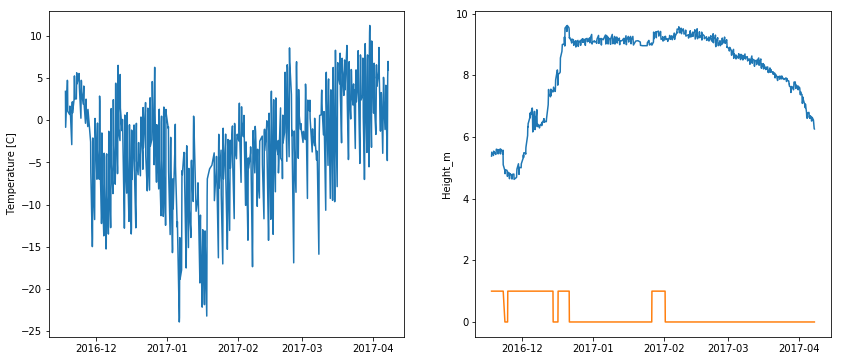

In [43]:
fig=plt.figure(figsize=(14,6))
ax=fig.add_subplot(1,2,1)
plt.plot(df[['temp']])
ax.set_ylabel('Temperature [C]')
ax=fig.add_subplot(1,2,2)
plt.plot(df[['height']])
plt.plot(df['water'])
ax.set_ylabel('Height_m')


The orange binary steps indicate fountain supply on/off